In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from utils.utils_vis import axis_font_size, ticks_font_size, title_font_size, width_in_inches, Colors, pk_param_names, param_units, pk_param_units
from utils.utils_numpy import nrmse
from scipy.stats import ttest_ind, shapiro, levene, wilcoxon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
# matplotlib.use('TkAgg')


mode= "ood"
save = False

model_paths = {
    # "NLLS" : "output/ood/nlls",
    # "snn" : "output/ood/snn_dcenet_3/predictions",
    "PINN" : "output/ood/pinn_ph_dcenet_3/predictions",
    "PINN (ens)": "output/ood/pinn_ph_dcenet_ens/predictions",
    "MVE" : "output/ood/mve_snn_dcenet_4/predictions",
    # "mve (pi)" : "output/ood/mve_pinn_dcenet_3/predictions",
    "MVE (ens)" : "output/ood/mve_snn_dcenet_ens/predictions",
    # "mve (pi, ens)" : "output/ood/mve_pinn_dcenet_ens/predictions",
}

In [9]:
if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

In [10]:
test_data = np.load("data/sim/normal_ood/test.npz")
train_data = np.load("data/sim/normal_ood/train.npz")
parameters = ["$k_e$", "$v_e$", "$v_p$"]
print(f"keys in dataset: {list(train_data.keys())}")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

keys in dataset: ['params', 'concentrations', 'snr']


In [11]:
preds = {
    model: np.load(os.path.join(model_paths[model], "test_preds.npz")) for model in model_paths
}
means = {
    model: preds[model]['pred'][:,[0,2,3]] for model in model_paths
}
vars = {
    model: preds[model]['var'][:,[0,2,3]] for model in model_paths
}
var_pinn_ens_ep = preds["PINN (ens)"]['var_ep'][:,[0,2,3]]
# var_pinn_ens_ep = (var_pinn_ens_ep / var_pinn_ens_ep.mean(axis=0)) * vars["MVE (ens)"].mean(axis=0)
vars["PINN (ens-ep)"] = var_pinn_ens_ep
means["PINN (ens-ep)"] = preds["PINN (ens)"]['pred'][:,[0,2,3]]
var_snn_ens_ep = preds["MVE (ens)"]['var_ep'][:,[0,2,3]]
# var_snn_ens_ep = (var_snn_ens_ep / var_snn_ens_ep.mean(axis=0)) * vars["MVE (ens)"].mean(axis=0)
vars["MVE (ens-ep)"] = var_snn_ens_ep
means["MVE (ens-ep)"] = preds["MVE (ens)"]['pred'][:,[0,2,3]]

vars = {
    model: np.maximum(vars[model], 0) for model in means
}
pred_errors = {
    model: np.sqrt(vars[model]*2/np.pi) for model in means
}
ood_cutoff = train_data["params"].max(axis=0)[[0,2,3]]
train_params = train_data["params"][:,[0,2,3]]
test_params = test_data["params"][:,[0,2,3]]
errors = {
    model: np.abs(means[model] - test_params) for model in means
}
bounds = [3,1,1]

outliers = {
    model: (vars[model] > bounds) for model in means
}

for model, ol in outliers.items():
    print(f"{model}: {(100*ol.sum(axis=0) / (ol.size/3)).round(2)}% outliers")
    # remove outliers from pred_errors, errors, means, vars

print(f"OOD cutoff: {ood_cutoff}")
ood_mask_test = test_params > ood_cutoff
print(f"OOD percentage: {(100*ood_mask_test.sum() / ood_mask_test.size).round(3)}%")
print(f"OOD number: {ood_mask_test.sum(axis=0)}")
# 

PINN: [1.41 0.06 0.05]% outliers
PINN (ens): [1.67 0.21 0.16]% outliers
MVE: [0. 0. 0.]% outliers
MVE (ens): [0. 0. 0.]% outliers
PINN (ens-ep): [0. 0. 0.]% outliers
MVE (ens-ep): [0. 0. 0.]% outliers
OOD cutoff: [2.37985948 0.78470999 0.19506559]
OOD percentage: 8.983%
OOD number: [ 45174 297524  61535]


<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_49247/442468293.py:38: SyntaxWarning: invalid escape sequence '\s'
  ax2.plot(bins[:-1], avg_epistemic_uncertainties, color="green", label="Average uncertainty $(\sigma^2)$")
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_49247/442468293.py:41: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel("Average uncertainty $(\sigma^2)$", fontsize=axis_font_size)
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_49247/442468293.py:15: RuntimeWarning: Mean of empty slice.
  avg_errors = [error[bin_indices == j].mean() for j in range(1, len(bins))]
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = 

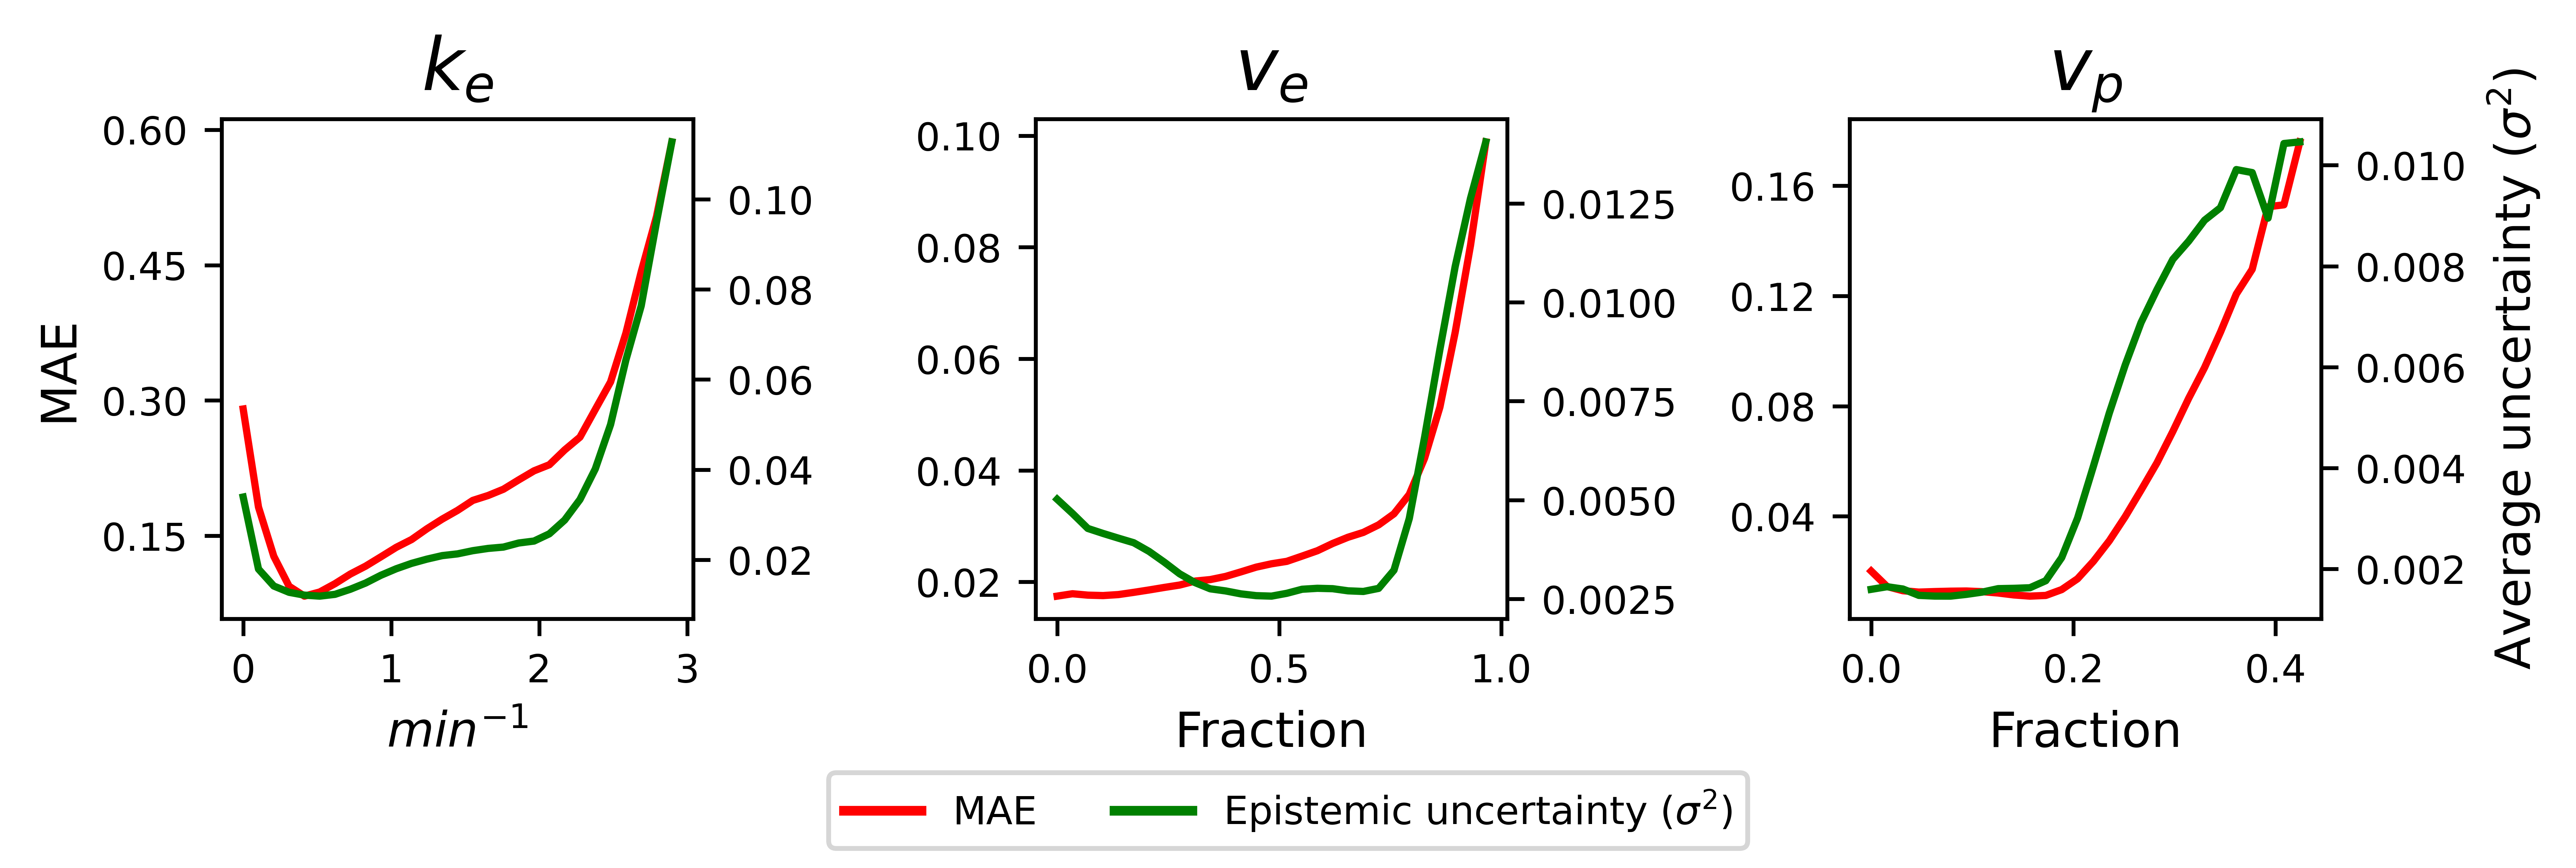

In [8]:
model = "PINN (ens-ep)"
# model = "MVE (ens-ep)"
fig, axs = plt.subplots(1, 3, figsize=(width_in_inches, width_in_inches / 3), sharey=False, dpi=1000)

for i, ax in enumerate(axs):
    ax.set_title(pk_param_names[i], fontsize=title_font_size)

    # Compute binning and statistics
    bins = np.linspace(test_params[:, i].min(), test_params[:, i].max(), 30)
    bin_indices = np.digitize(test_params[:, i], bins)

    # Filter out outliers
    error = errors[model][:, i]
    error = error[outliers[model][:, i] == 0]
    avg_errors = [error[bin_indices == j].mean() for j in range(1, len(bins))]

    epistemic_uncertainties = np.sqrt(np.clip(
        preds["MVE (ens)"]['var_ep'][:, [0, 2, 3]][:, i], a_min=0., a_max=np.inf
    ))
    epistemic_uncertainties = epistemic_uncertainties[outliers[model][:, i] == 0]
    avg_epistemic_uncertainties = [epistemic_uncertainties[bin_indices == j].mean() for j in range(1, len(bins))]

    # Plot Error on left axis
    ax.plot(bins[:-1], avg_errors, color="red", label="MAE")
    ax.set_xlabel(f"{pk_param_units[i]}", fontsize=axis_font_size)
       # Only label left y-axis on the first plot
    if i == 0:
        ax.set_ylabel("MAE", fontsize=axis_font_size)
    # else:
    #     ax.tick_params(axis='y', labelleft=False)
    # set ytick size
    # ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='both', labelsize=ticks_font_size)
    ax.yaxis.set_major_locator(MaxNLocator(5))

    # Create secondary axis for uncertainty
    ax2 = ax.twinx()
    ax2.plot(bins[:-1], avg_epistemic_uncertainties, color="green", label="Average uncertainty $(\sigma^2)$")
    # Only label right y-axis on the last plot
    if i == len(axs) - 1:
        ax2.set_ylabel("Average uncertainty $(\sigma^2)$", fontsize=axis_font_size)
    # else:
    #     ax2.tick_params(axis='y', labelright=False)
    ax2.tick_params(axis='y', labelsize=ticks_font_size)
    # set max y ticks
    ax2.yaxis.set_major_locator(MaxNLocator(6))
# Custom legend (only green and red lines)
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='MAE'),
    Line2D([0], [0], color='green', lw=2, label='Epistemic uncertainty ($\\sigma^2)$'),
]

# fig.suptitle("Parameter-Uncertainty Distributions", fontsize=title_font_size)
fig.legend(handles=legend_elements, loc='lower center', ncols=len(legend_elements), fontsize=ticks_font_size)
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

if save:
    fig.savefig(f"{outpath}/epistemic/ood_supervised_ensemble.jpg", format="jpg", dpi=1000)


<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_11727/1941772468.py:38: SyntaxWarning: invalid escape sequence '\s'
  ax2.plot(bins[:-1], avg_epistemic_uncertainties, color="green", label="Avg. uncertainty $(\sigma^2)$")
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_11727/1941772468.py:40: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel("Mean uncertainty $(\sigma^2)$", fontsize=axis_font_size)
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_11727/1941772468.py:18: RuntimeWarning: Mean of empty slice.
  avg_errors = [error[bin_indices[valid_mask] == j].mean() for j in range(1, len(bins))]
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide

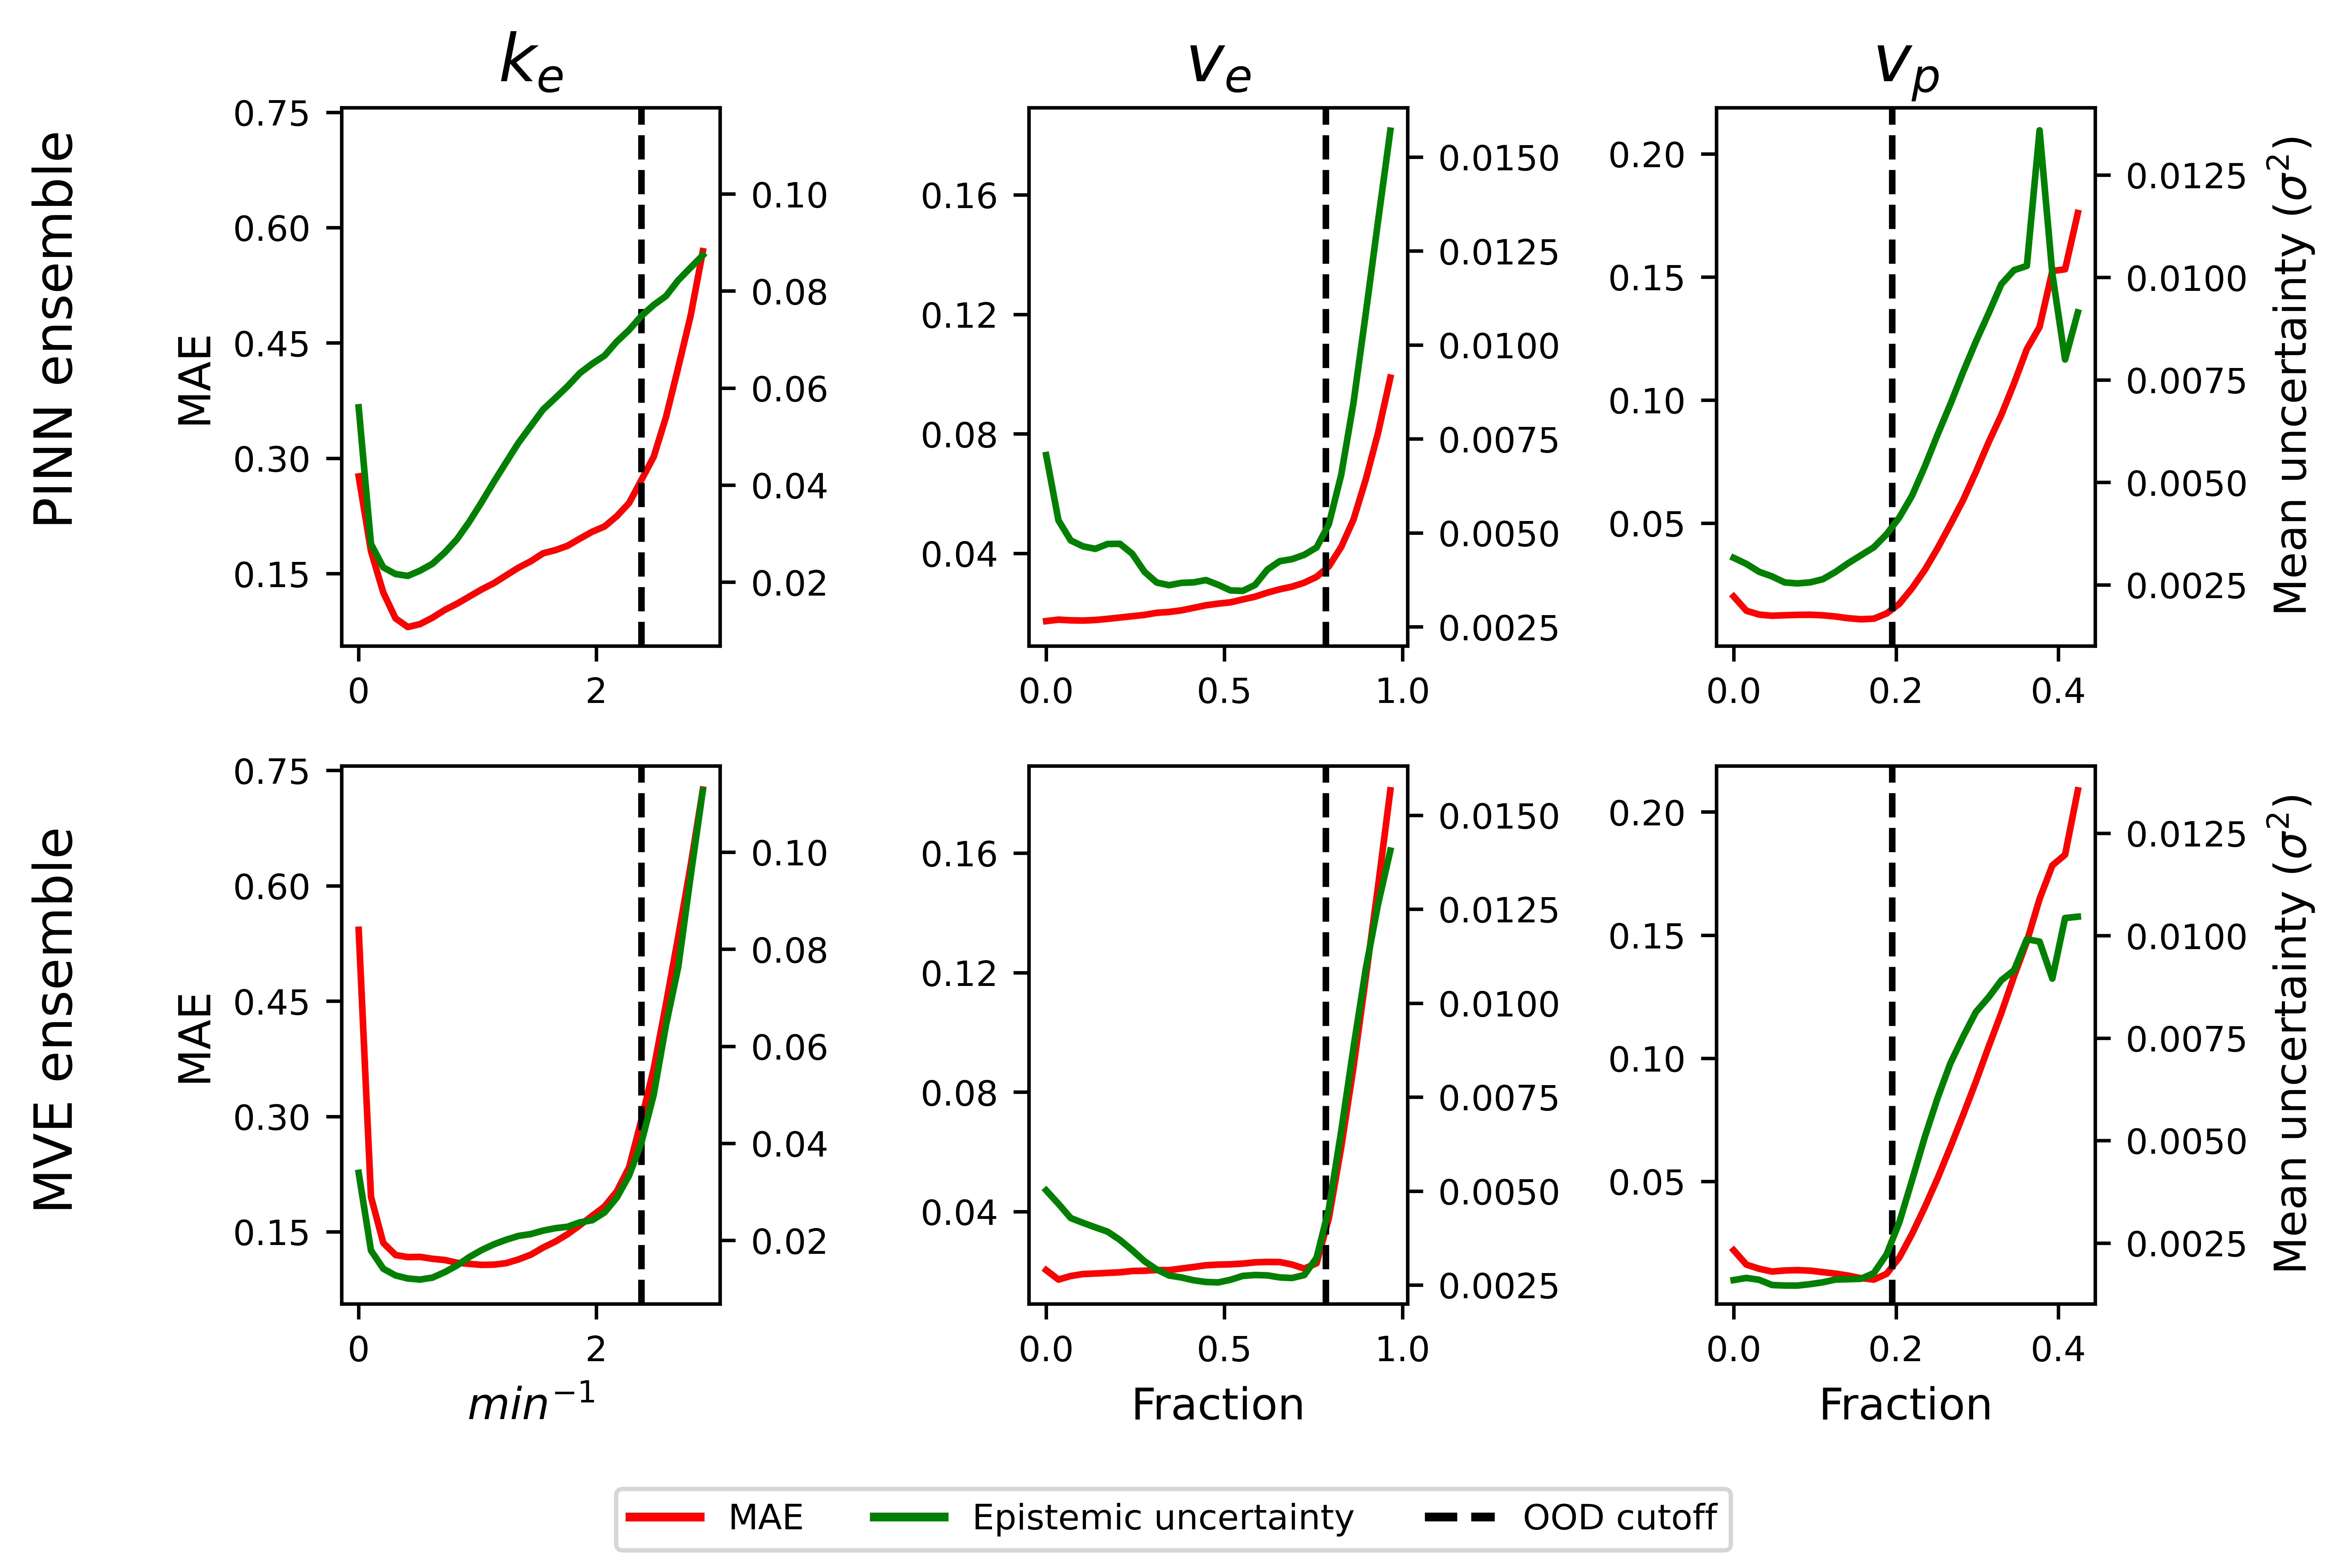

In [12]:
models = ["PINN (ens)", "MVE (ens)"]
fig, axs = plt.subplots(2, 3, figsize=(width_in_inches, 2 * width_in_inches / 3), sharey=False, dpi=1000)
twin_axes = [[None for _ in range(3)] for _ in range(2)]
for row, model in enumerate(models):
    for i in range(3):
        ax = axs[row, i]
        if row == 0:
            ax.set_title(pk_param_names[i], fontsize=title_font_size)

        # Compute binning and statistics
        bins = np.linspace(test_params[:, i].min(), test_params[:, i].max(), 30)
        bin_indices = np.digitize(test_params[:, i], bins)

        # Filter out outliers
        error = errors[model][:, i]
        valid_mask = outliers[model][:, i] == 0
        error = error[valid_mask]
        avg_errors = [error[bin_indices[valid_mask] == j].mean() for j in range(1, len(bins))]

        epistemic_uncertainties = np.sqrt(np.clip(
            preds[model]['var_ep'][:, [0, 2, 3]][:, i], a_min=0., a_max=np.inf
        ))
        epistemic_uncertainties = epistemic_uncertainties[valid_mask]
        avg_epistemic_uncertainties = [epistemic_uncertainties[bin_indices[valid_mask] == j].mean()
                                       for j in range(1, len(bins))]

        # Plot Error on left axis
        ax.plot(bins[:-1], avg_errors, color="red", label="MAE")
        if row == 1:
            ax.set_xlabel(f"{pk_param_units[i]}", fontsize=axis_font_size)
        if i == 0:
            ax.set_ylabel("MAE", fontsize=axis_font_size)
        ax.tick_params(axis='both', labelsize=ticks_font_size)
        ax.yaxis.set_major_locator(MaxNLocator(5))

        # Secondary y-axis for uncertainty
        ax2 = ax.twinx()
        ax2.plot(bins[:-1], avg_epistemic_uncertainties, color="green", label="Avg. uncertainty $(\sigma^2)$")
        if i == 2:
            ax2.set_ylabel("Mean uncertainty $(\sigma^2)$", fontsize=axis_font_size)
        ax2.tick_params(axis='y', labelsize=ticks_font_size)
        ax2.yaxis.set_major_locator(MaxNLocator(6))
        twin_axes[row][i] = ax2
        
        # Plot a vertical line at ood_cutoff[i]
        ax.axvline(x=ood_cutoff[i], color='black', linestyle='--', label="OOD cutoff")
        # # Add text label for OOD cutoff
        # ax.text(ood_cutoff[i], ax.get_ylim()[1] * 0.8, "OOD cutoff", fontsize=ticks_font_size,
        #         verticalalignment='center', horizontalalignment='right', color='black')
        
# Set consistent y-limits per column
for i in range(3):
    # Primary y-axis (MAE)
    y_lims = [axs[row, i].get_ylim() for row in range(2)]
    y_min = min(lim[0] for lim in y_lims)
    y_max = max(lim[1] for lim in y_lims)
    for row in range(2):
        axs[row, i].set_ylim(y_min, y_max)

    # Secondary y-axis (Uncertainty)
    y2_lims = [twin_axes[row][i].get_ylim() for row in range(2)]
    y2_min = min(lim[0] for lim in y2_lims)
    y2_max = max(lim[1] for lim in y2_lims)
    for row in range(2):
        twin_axes[row][i].set_ylim(y2_min, y2_max)


# Add model subtitles to left of each row
fig.text(0.01, 0.78, "PINN ensemble", va='center', ha='left', fontsize=title_font_size-3, rotation='vertical')
fig.text(0.01, 0.34, "MVE ensemble", va='center', ha='left', fontsize=title_font_size-3, rotation='vertical')

# Custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='MAE'),
    Line2D([0], [0], color='green', lw=2, label='Epistemic uncertainty'),
    Line2D([0], [0], color='black', lw=2, label='OOD cutoff', linestyle='--'),
]

fig.legend(handles=legend_elements, loc='lower center', ncols=3, fontsize=ticks_font_size)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])  # leave space on left for row labels
plt.show()

if save:
    fig.savefig(f"{outpath}/epistemic/ood_ensembles.jpg", format="jpg", dpi=1000)


Wilcoxon test for PINN (ens-ep) on $k_e$: w-statistic: 213606794.5, p-value: 0.0
Model: PINN (ens-ep), factor: 4.731256008148193
Wilcoxon test for MVE (ens-ep) on $k_e$: w-statistic: 223947943.0, p-value: 0.0
Model: MVE (ens-ep), factor: 3.9196276664733887
Wilcoxon test for PINN (ens-ep) on $v_e$: w-statistic: 4336955617.0, p-value: 0.0
Model: PINN (ens-ep), factor: 6.816666603088379
Wilcoxon test for MVE (ens-ep) on $v_e$: w-statistic: 2335166769.5, p-value: 0.0
Model: MVE (ens-ep), factor: 13.133333206176758
Wilcoxon test for PINN (ens-ep) on $v_p$: w-statistic: 320076632.0, p-value: 0.0
Model: PINN (ens-ep), factor: 2.826134443283081
Wilcoxon test for MVE (ens-ep) on $v_p$: w-statistic: 223266413.5, p-value: 0.0
Model: MVE (ens-ep), factor: 14.256937026977539


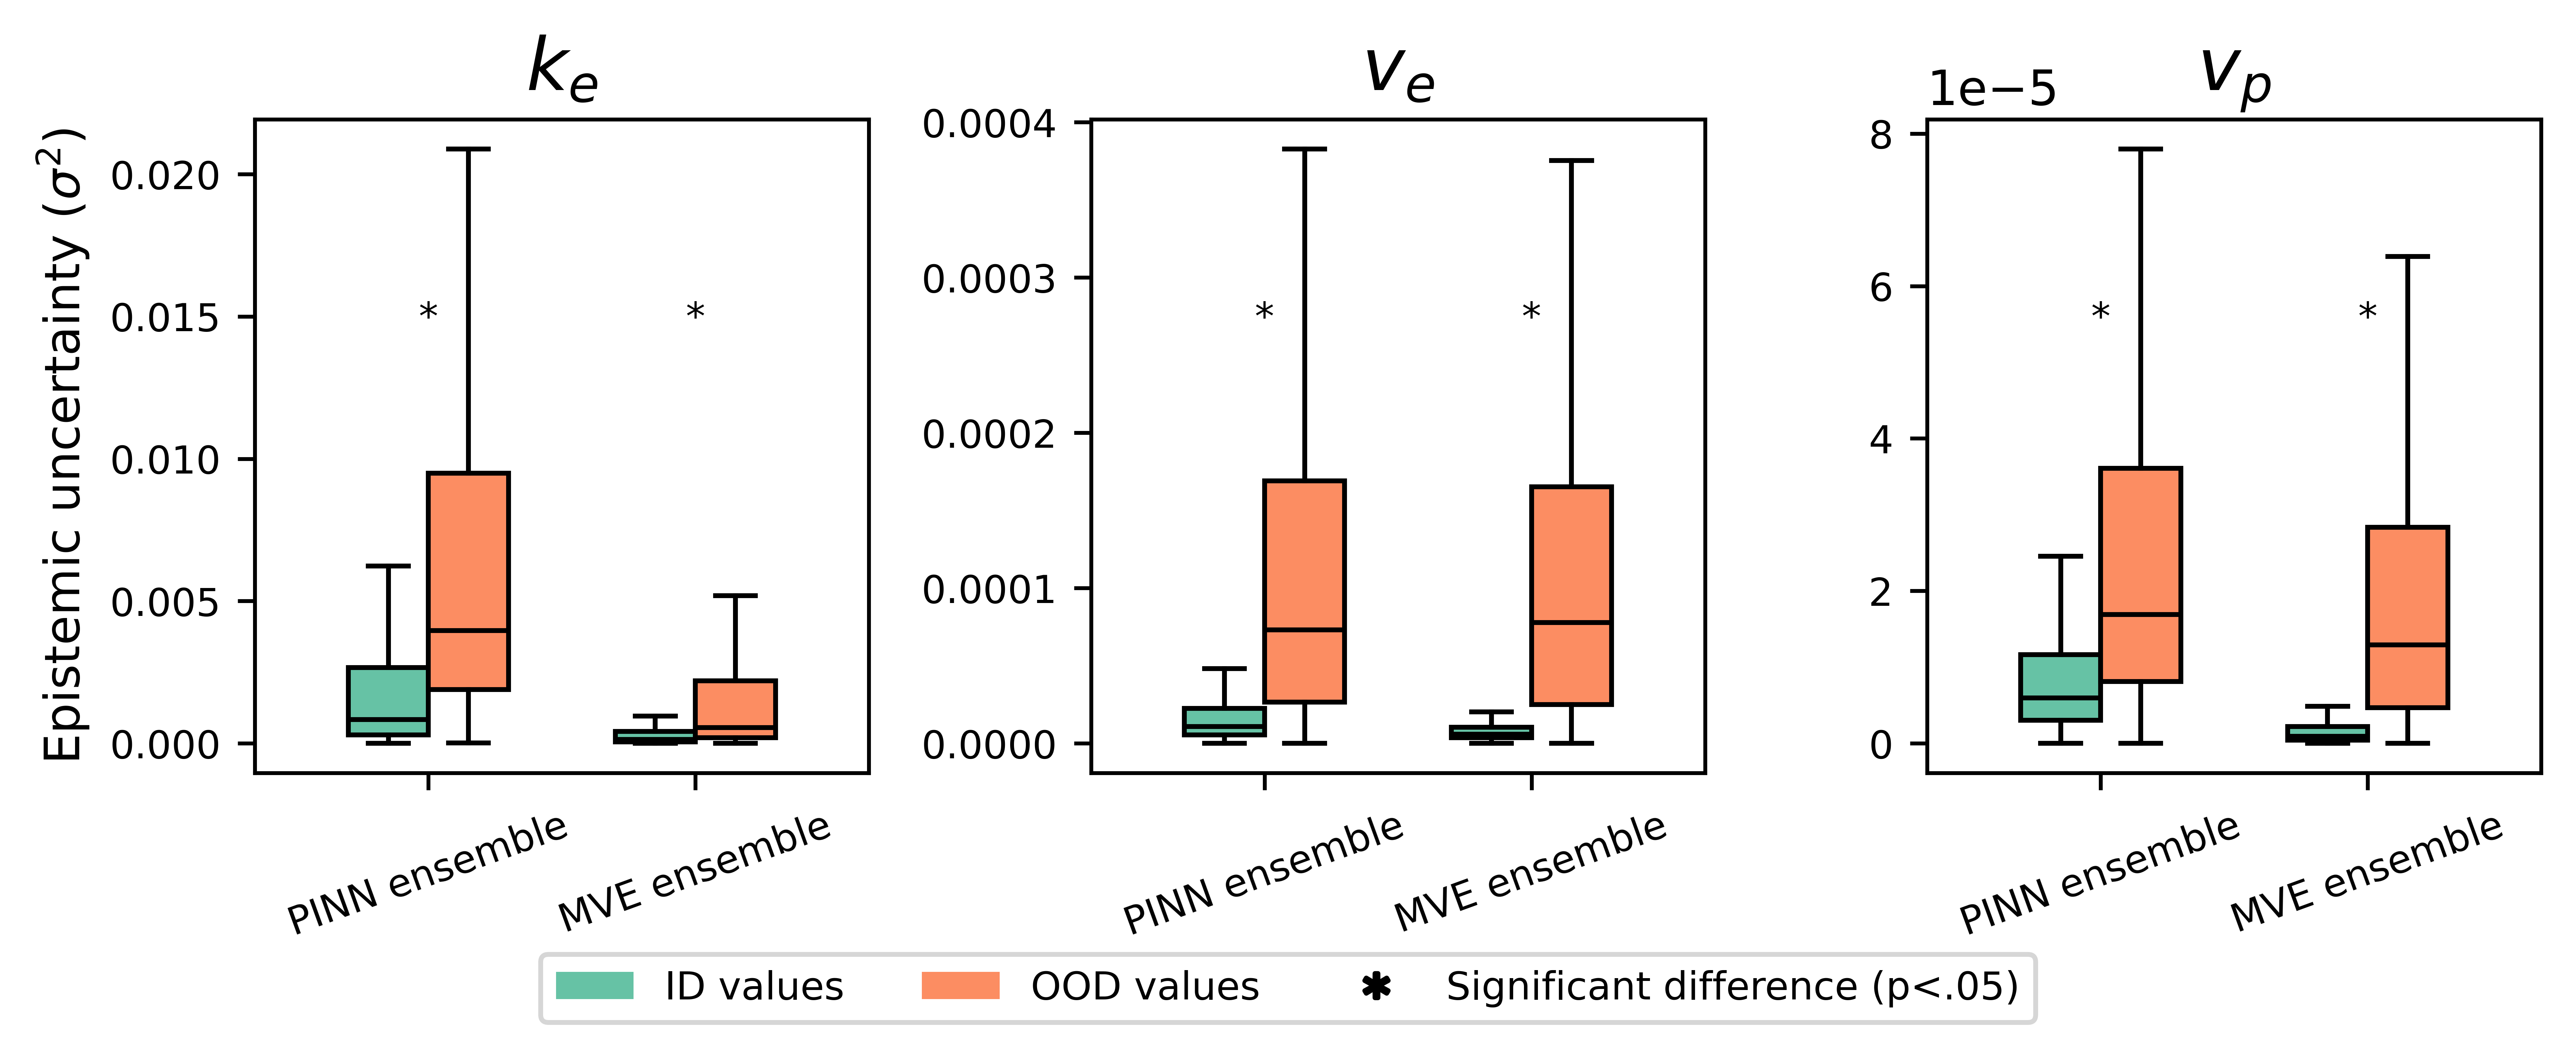

In [16]:
# plot boxplot of uncertainty predictions (vars) of all models between two categories: In distribution and OOD
fig, axs = plt.subplots(1,3, figsize=(width_in_inches, width_in_inches/2.5), dpi=1000)
# order = ["PINN", "PINN (ens)", "PINN (ens-ep)", "MVE", "MVE (ens)", "MVE (ens-ep)"]

# order = ["PINN (ens)", "PINN (ens-ep)", "MVE (ens)", "MVE (ens-ep)"]
# labels = ["PI ens", "PI ens", "MVE ens", "MVE ens"]

order = ["PINN (ens-ep)", "MVE (ens-ep)"]
labels = ["PINN ensemble", "MVE ensemble"]

vars = {model:vars[model] for model in order}
for i, param in enumerate(parameters):
    vars_ind = [vars[model][:,i][~ood_mask_test[:,i] & ~outliers[model][:,i]] for model in vars]
    vars_ood = [vars[model][:,i][ood_mask_test[:,i] & ~outliers[model][:,i]] for model in vars]

    bp_ind = axs[i].boxplot(vars_ind, positions=np.arange(len(vars))-0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor=color_cycle[0]), medianprops=dict(color='black'))
    bp_ood = axs[i].boxplot(vars_ood, positions=np.arange(len(vars))+0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor=color_cycle[1]), medianprops=dict(color='black'))
    for j, box in enumerate(bp_ind['boxes']):
        box.set_facecolor(color_cycle[0])
        model = order[j]
        # if 'ep' in model:
            # box.set_hatch('///')
    for j, box in enumerate(bp_ood['boxes']):
        box.set_facecolor(color_cycle[1])
        model = order[j]
        # if 'ep' in model:
            # box.set_hatch('///')

    sig = {model: False for model in vars}
    for j, model in enumerate(order):
        # do rank test
        N = len(vars_ood[j])
        w_stat, p_val = wilcoxon(vars_ind[j][:N], vars_ood[j], alternative="less")
        factor = np.median(vars_ood[j]) / np.median(vars_ind[j])

        print(f"Wilcoxon test for {model} on {param}: w-statistic: {w_stat}, p-value: {p_val}")
        print(f"Model: {model}, factor: {factor}")

        if p_val < 0.05:
            sig[model] = True
    # add significance markers
    for j, model in enumerate(order):
        if sig[model]:
            y_max = axs[i].get_ylim()[1]
            axs[i].text(x=j, y=y_max*0.65, s="*", ha='center', va='bottom', fontsize=ticks_font_size)

    axs[i].set_xticks(np.arange(len(vars)))
    axs[i].set_xticklabels(labels, rotation=20)
    # axs[i].set_xlabel("Model", fontsize=axis_font_size)
    axs[i].set_title(f"{pk_param_names[i]} ({param_units[i]})", fontsize=title_font_size)

    axs[i].set_title(param, fontsize=title_font_size)
    if i == 0:
        axs[i].set_ylabel("Epistemic uncertainty ($\\sigma^2$)")
    axs[i].tick_params(axis='both', which='major', labelsize=ticks_font_size)
    axs[i].tick_params(axis='both', which='minor', labelsize=ticks_font_size-2)
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

# fig.suptitle("Uncertainty in- and out-of-distribution", fontsize=title_font_size)

legend_elements = [
    Patch(facecolor=color_cycle[0], label='ID values'),
    Patch(facecolor=color_cycle[1], label='OOD values'), 
    # Patch(facecolor='white', edgecolor='black', hatch='///', label='Epistemic estimate'),
    Line2D([0], [0], color='none', marker='$*$', markersize=5, label='Significant difference (p<.05)', markerfacecolor='black')
    ]
fig.legend(handles=legend_elements, loc='lower center', fontsize=ticks_font_size, ncols=len(legend_elements))
fig.tight_layout(rect=[0, 0.03, 1, 1])
if save:
    plt.savefig(f"{outpath}/epistemic/classification.jpg", format='jpg', dpi=1000)

In [13]:
vars['PINN (ens-ep)']

array([[5.2714348e-04, 2.7418137e-06, 2.3022294e-06],
       [3.8003922e-04, 4.2617321e-06, 1.3280660e-06],
       [3.1572580e-04, 2.2202730e-05, 1.0720221e-05],
       ...,
       [9.6559525e-04, 9.8228455e-05, 5.5488199e-06],
       [4.4427156e-02, 2.7786009e-05, 5.1259995e-06],
       [1.0204911e-03, 4.8875809e-06, 2.7630944e-05]], dtype=float32)

<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_42426/2268014761.py:64: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel("Avg. uncertainty $(\sigma^2)$", fontsize=axis_font_size)
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_42426/2268014761.py:30: RuntimeWarning: Mean of empty slice.
  avg_errors = [error[bin_indices[valid_mask] == j].mean() for j in range(1, len(bins))]
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_42426/2268014761.py:36: RuntimeWarning: Mean of empty slice.
  avg_epistemic_uncertainties = [epistemic_uncertainties[bin_indices[valid_mask] == j].mean()
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_met

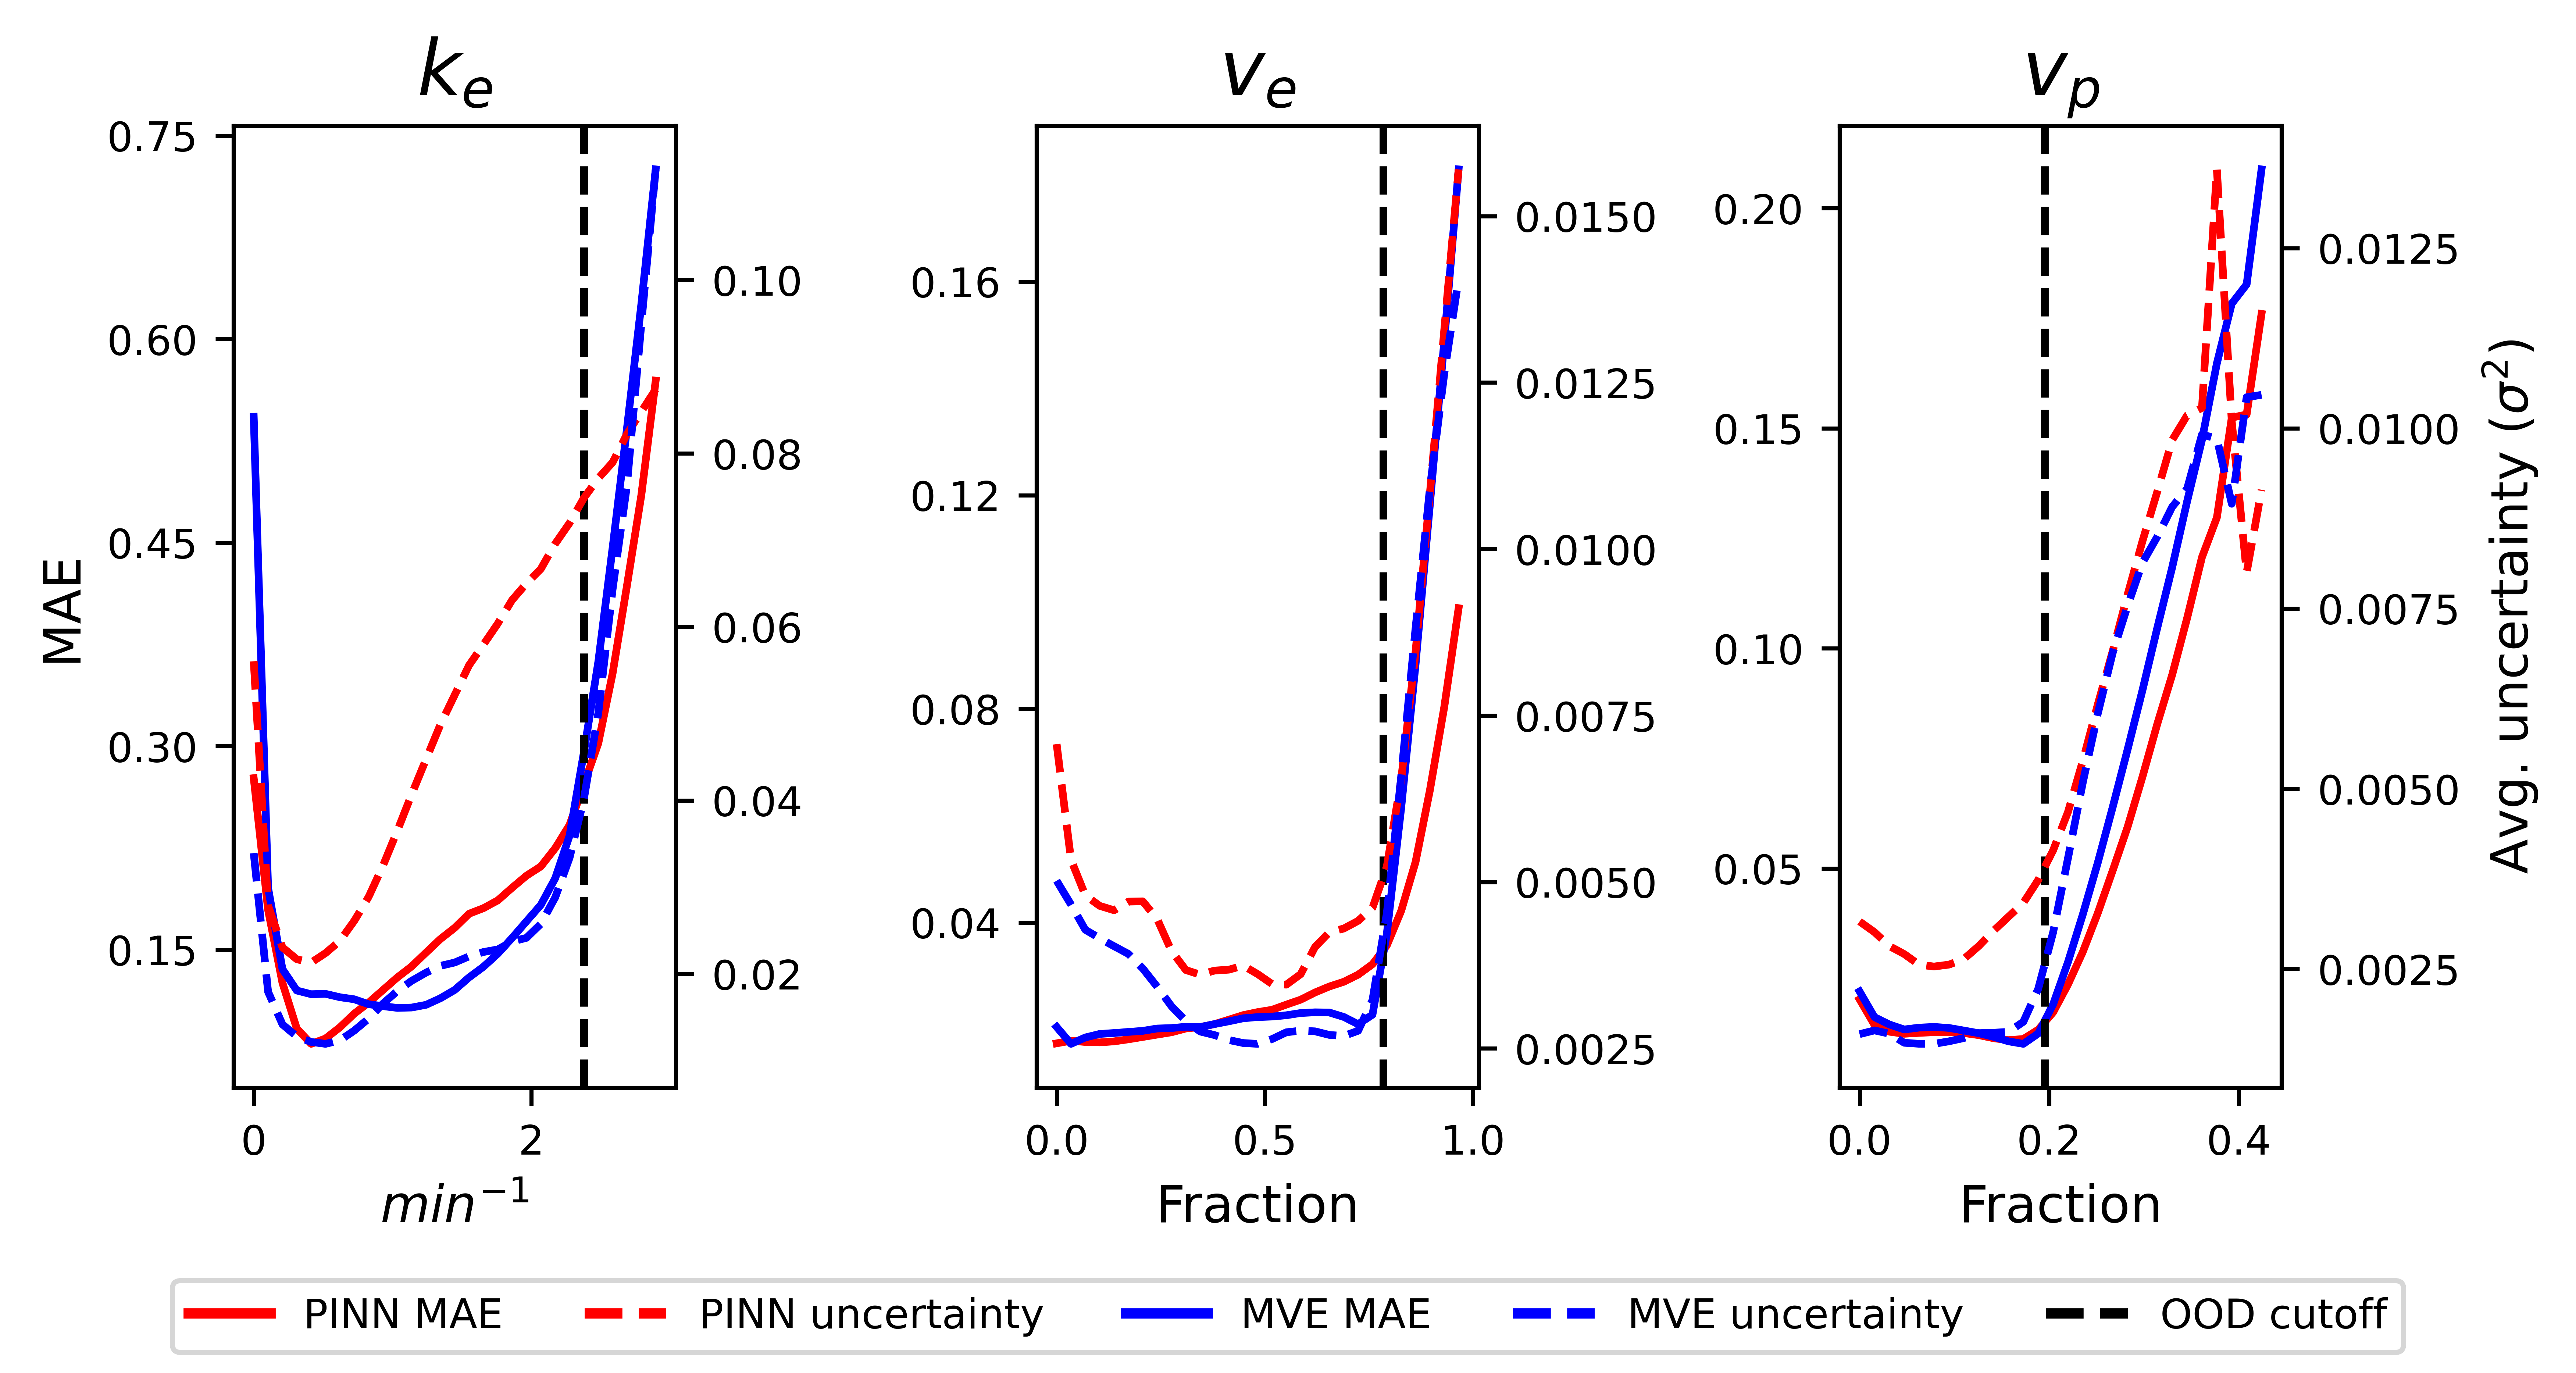

In [ ]:
model_colors = {
    "PINN (ens)": "red",
    "MVE (ens)": "blue"
}
model_labels = {
    "PINN (ens)": "PINN ensemble",
    "MVE (ens)": "MVE ensemble"
}

fig, axs = plt.subplots(1, 3, figsize=(width_in_inches, width_in_inches / 2), dpi=1000)
twin_axes = []

for i in range(3):  # For each parameter/column
    ax = axs[i]
    ax.set_title(pk_param_names[i], fontsize=title_font_size)

    # Shared y-axis containers to equalize later
    primary_y_lims = []
    secondary_y_lims = []

    for model in models:
        # Compute binning and statistics
        bins = np.linspace(test_params[:, i].min(), test_params[:, i].max(), 30)
        bin_indices = np.digitize(test_params[:, i], bins)

        # Filter out outliers
        error = errors[model][:, i]
        valid_mask = outliers[model][:, i] == 0
        error = error[valid_mask]
        avg_errors = [error[bin_indices[valid_mask] == j].mean() for j in range(1, len(bins))]

        epistemic_uncertainties = np.sqrt(np.clip(
            preds[model]['var_ep'][:, [0, 2, 3]][:, i], a_min=0., a_max=np.inf
        ))
        epistemic_uncertainties = epistemic_uncertainties[valid_mask]
        avg_epistemic_uncertainties = [epistemic_uncertainties[bin_indices[valid_mask] == j].mean()
                                       for j in range(1, len(bins))]

        # Plot error on left axis
        ax.plot(bins[:-1], avg_errors, color=model_colors[model], linestyle='-', label=f"{model_labels[model]} MAE")

        # Plot uncertainty on right axis
        if model == models[0]:  # Create twin axis only once
            ax2 = ax.twinx()
            twin_axes.append(ax2)
        ax2 = twin_axes[i]
        ax2.plot(bins[:-1], avg_epistemic_uncertainties, color=model_colors[model], linestyle='--',
                 label=f"{model_labels[model]} uncertainty")

        # Track y-limits
        primary_y_lims.append(ax.get_ylim())
        secondary_y_lims.append(ax2.get_ylim())

    # X-axis labeling
    ax.set_xlabel(f"{pk_param_units[i]}", fontsize=axis_font_size)
    ax.tick_params(axis='both', labelsize=ticks_font_size)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax2.tick_params(axis='y', labelsize=ticks_font_size)
    ax2.yaxis.set_major_locator(MaxNLocator(6))

    if i == 0:
        ax.set_ylabel("MAE", fontsize=axis_font_size)
    if i == 2:
        ax2.set_ylabel("Mean uncertainty $(\sigma^2)$", fontsize=axis_font_size)

    # Equalize y-limits across models for this column
    y_min = min(lim[0] for lim in primary_y_lims)
    y_max = max(lim[1] for lim in primary_y_lims)
    ax.set_ylim(y_min, y_max)

    y2_min = min(lim[0] for lim in secondary_y_lims)
    y2_max = max(lim[1] for lim in secondary_y_lims)
    ax2.set_ylim(y2_min, y2_max)

    # OOD cutoff line
    ax.axvline(x=ood_cutoff[i], color='black', linestyle='--', label="OOD cutoff")

# Custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, linestyle='-', label='PINN MAE'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='PINN uncertainty'),
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='MVE MAE'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='MVE uncertainty'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='OOD cutoff'),
]

fig.legend(handles=legend_elements, loc='lower center', ncols=5, fontsize=ticks_font_size)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

if save:
    fig.savefig(f"{outpath}/epistemic/ood_combined_ensembles.jpg", format="jpg", dpi=1000)
